In [156]:
import numpy as np
from skimage import io
import napari
import pandas as pd
import zarr
import os
import pickle
import matplotlib.pyplot as plt 
import cv2
from cellpose import models
import tiffile as tf
import glob

### Make data for training
Assume training data is double color. One for the channel to get segmented and another for cytosol/nuclei.

In [157]:
##### change path
# first path need to be first brain,second path need to be another brain
fix_n5_path = ['/mnt/aperto/fused/fused.n5','/mnt/aperto/fused/fused.n5']

# save path
#create the directory if it does not exist
##### change path
# you need to change to the folder you want
directory = './crops/'
if not os.path.exists(directory):
    os.makedirs(directory)
    print("Directory created:", directory)
##### change path
# you need to change to the folder you want
save_path = './crops'
##### change path
#you need to change to the folder you want metadata path
meta_path = './info.pkl'

# create Zarr file object
fix_zarr = [zarr.open(store=zarr.N5Store(fix_n5_path[0]), mode='r'), zarr.open(store=zarr.N5Store(fix_n5_path[1]), mode='r')]
# if you use ngff ome.zarr
# mov_zarr_path = '/mnt/ampa02_data01/tmurakami/240417_whole_4color_1st_M037-3pb/registration/round02.zarr'
# mov_zarr = zarr.open(mov_zarr_path, mode='r')

n5_setups = list(fix_zarr[0].keys())

voxel_size = (2.0,1.3,1.3)

Directory created: ./crops/


/tmp/ipykernel_1065286/3011447890.py:21: FutureWarning: The N5Store is deprecated and will be removed in a Zarr-Python version 3, see https://github.com/zarr-developers/zarr-python/issues/1274 for more information.
  fix_zarr = [zarr.open(store=zarr.N5Store(fix_n5_path[0]), mode='r'), zarr.open(store=zarr.N5Store(fix_n5_path[1]), mode='r')]


In [158]:
# set your parameters here
reference_chan = 3 # Integer or None
segment_chan = 4

# [100,256,256] crop size and FoV [100,768,768] are recommended for the 2D annotation
crop_size = [100,256,256]
FoV = [100,768,768]

# set corner positions. I suggest finding the positions using BigDataViewer or relevant.
# use the fourth column to add information
center_positions = [
    [1235,2510,775, 1],
    [1325,3350,1542,2],
    [1725,4632,1602]
]

corner_positions = [[(i-j//2) for i,j in zip(cent_pos, crop_size + [0])] for cent_pos in center_positions]

# set True for 2D annotation and set False for 3D annotation
select_plane = True

# processing of parameters
if not all([(j-i)>=0 for i,j in zip(crop_size, FoV)]):
    raise ValueError('FoV should be larger than crop_size')

In [159]:
corner_positions

[[1185, 2382, 647, 1], [1275, 3222, 1414, 2], [1675, 4504, 1474]]

In [160]:
# make metadata file if it does not exist.
if not os.path.exists(meta_path):
    df = pd.DataFrame(columns=['ID', 'integer_ID', 'instance_counts', 'corner', 'source', 'ref_channel', 'channel', 'crop_size', 'isHard', 'plane_position'])
else:
    df = pd.read_pickle(meta_path)


In [161]:
# if you have trouble like ImportError: cannot import name 'fastCopyAndTranspose' from 'numpy.core.multiarray' 
# try this
#!pip install --upgrade numpy

### Add cellpose prediction

#### load original data and get the image wan to label

In [162]:
with open('./annotation_position_info.pkl', 'rb') as f:
    ori_data = pickle.load(f)

/tmp/ipykernel_1065286/2941550060.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  ori_data = pickle.load(f)


In [163]:
# find all files in the directory ending with '_img.tif', and '_mask.tif' 
##### change path
#you need to change this path to your image and mask file path
img_dir = '/mnt/aperto/yin/cellpose_training/data/image_masks/' 
img_files = sorted(glob.glob(f'{img_dir}*_img.tif'))
mask_files = sorted(glob.glob(f'{img_dir}*mask.tif'))
img_id = [item.split('/')[-1][:4] for item in img_files]

In [164]:
# check all the id are valid
for item in img_id:
    try:
        ori_data.iloc[int(item)]
    except:
       print(item, 'invalid id')

In [165]:
# example from original data frame
ori_data.head(5)

,ID,integer_ID,instance_counts,corner,source,ref_channel,channel,crop_size,select_plane,isHard,plane_position
0,0000,0,23,"[1061, 4601, 560]",/mnt/ampa02_data01/tmurakami/240417_whole_4col...,3,1,"[100, 256, 256]",True,0.0,24.0
1,0001,1,58,"[1325, 3350, 1543]",/mnt/ampa02_data01/tmurakami/240417_whole_4col...,3,1,"[100, 256, 256]",True,0.0,25.0
2,0002,2,5,"[1356, 517, 1669]",/mnt/ampa02_data01/tmurakami/240417_whole_4col...,3,1,"[100, 256, 256]",True,0.0,52.0
3,0003,3,7,"[1354, 566, 3633]",/mnt/ampa02_data01/tmurakami/240417_whole_4col...,3,1,"[100, 256, 256]",True,0.0,42.0
4,0004,4,27,"[1331, 2013, 706]",/mnt/ampa02_data01/tmurakami/240417_whole_4col...,3,1,"[100, 256, 256]",True,0.0,60.0


In [166]:
# optional run, check source of data
set(ori_data['source'])

{'/mnt/ampa02_data01/tmurakami/240417_whole_4color_1st_M037-3pb/fused/fused.n5',
 '/mnt/ampa02_data01/tmurakami/240425_whole_4color_2nd_M037-3pb/fused/fused.n5'}

In [172]:
# optional run, check source of data
source1 = []
source2 = []
for i in range(len(ori_data)):
    if ori_data['source'][i].split('/')[-3] == '240417_whole_4color_1st_M037-3pb':
        source1.append(i)
    elif ori_data['source'][i].split('/')[-3] == '240425_whole_4color_2nd_M037-3pb':
        source2.append(i)
        

#### load cellpose prediction

In [174]:
# you need to change path to your pkl path
with open('./cellpose_nonorm_all.pkl', 'rb') as f:
    nonorm_data = pickle.load(f)

#print(f"loading file: {nonorm_data}")

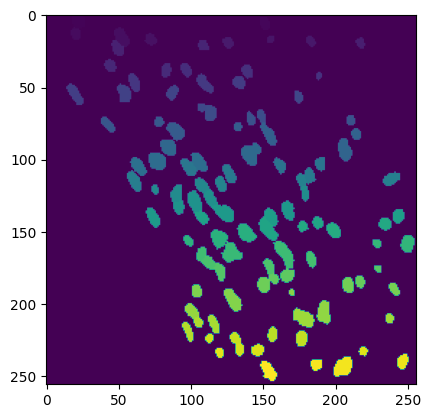

In [175]:
# exampld of cellpose prediction
plt.imshow(nonorm_data['0172'])

### Load all masks outlines

In [208]:
with open('./image_outlines.pkl', 'rb') as f:
    outline_data = pickle.load(f)

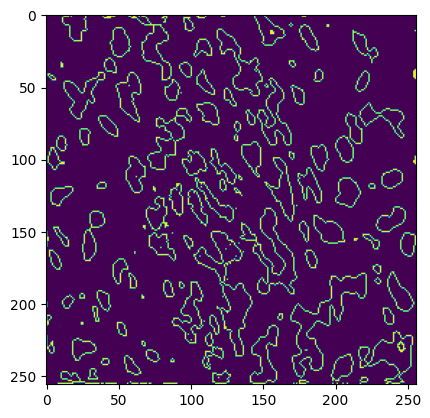

In [177]:
plt.imshow(outline_data['0172'])

In [178]:
begin_id = 0

In [191]:
for ori_id in img_id[begin_id:]:
    ori_corner_position = [ori_data['corner'][int(ori_id)]]
    ori_plane = int(ori_data['plane_position'][int(ori_id)])
    segment_chan = int(ori_data['channel'][int(ori_id)])
    reference_chan =  int(ori_data['ref_channel'][int(ori_id)])
    #check which source it should be int 0 or 1
    brain_source = int(ori_data['source'][int(ori_id)].split('/')[-3].split('_')[-2][0])-1
    #you can check whether can get them correctly
    #print(corner_positions_orignal)
    #print(segment_chan,reference_chan)
    #print(segment_chan,reference_chan)
    #print(cellpose_predict.shape)
    #print('brain source', brain_source)

    ##########
    ## add cellpose prediction
    try:
        cellpose_predict = nonorm_data[ori_id]
    except:
        print(f'this id {ori_id} is exceed original id range, continue')
        continue
    
    # expand cellpose_prediction to correct size
    # create a 256x256 array of zeros
    single_layer = np.zeros((768, 768))
    # stack this array 100 times along a new axis (axis=0)
    prediction_label_stack = np.stack([single_layer] * 100, axis=0)
    expanded_array = np.zeros((768, 768))
    # Calculate the starting indices to place the 256x256 array in the center
    start_index = (768 - 256) // 2
    # Place the 256x256 array in the center of the 768x768 array
    expanded_array[start_index:start_index+256, start_index:start_index+256] = cellpose_predict
    prediction_label_stack[ori_plane] = expanded_array
    prediction_label_stack = prediction_label_stack.astype(int)
    
    # you can verify the result
    # print(prediction_label_stack.shape)  
    # print(prediction_label_stack.dtype)  
    # plt.imshow(expanded_array)
    # break
    
    #########
    ## add outlines image
    outline_predict = outline_data[ori_id]
    # expand cellpose_prediction to correct size
    # create a 256x256 array of zeros
    single_layer = np.zeros((768, 768))
    # stack this array 100 times along a new axis (axis=0)
    outline_stack = np.stack([single_layer] * 100, axis=0)
    expanded_array = np.zeros((768, 768))
    # Calculate the starting indices to place the 256x256 array in the center
    start_index = (768 - 256) // 2
    # Place the 256x256 array in the center of the 768x768 array
    expanded_array[start_index:start_index+256, start_index:start_index+256] = outline_predict
    outline_stack[ori_plane] = expanded_array
    outline_stack = outline_stack.astype(int)

    pos = ori_corner_position[0]
    if len(pos) <= 2:
        raise ValueError('The position should have length 3')
    elif len(pos) == 3:
        isHard = 0
    elif len(pos) == 4:
        isHard = pos[-1]
        pos = pos[:-1]
    else:
        raise ValueError('You have a wrong position format')
        
    print(f"The index {ori_id} with the position {pos}")
    idx = int(ori_id)
    
    # find out any duplication between the current data and the metadata
    # if it is duplicated, ask 
    flag = False
    if df['corner'].isin([pos]).any():
        for k in df['integer_ID'][df['corner'].isin([pos])].to_list():
            if ((df.loc[k,'source'] == fix_n5_path[brain_source]) and 
                (df.loc[k,'ref_channel'] == reference_chan) and 
                (df.loc[k,'channel'] == segment_chan) and 
                (df.loc[k,'crop_size'] == crop_size) and
                (df.loc[k,'select_plane'] == select_plane)):
                flag = True
                idx = k
    
    if flag:
        ans = input("Do you want to re-analyze the data? y or n")
        if ans != 'y':
            continue
        
    # set file path to be saved for both image and mask
    prefix = str(idx)
    while len(prefix) < 4:
        prefix = '0' + prefix
    img_path = os.path.join(save_path, prefix+'_img.tif')
    mask_path = [os.path.join(save_path, prefix+'_mask1.tif')
                ,os.path.join(save_path, prefix+'_mask2.tif')
                ,os.path.join(save_path, prefix+'_mask3.tif')]

    #### get which sources

    # get the image of a channel to be segmented
    FoV_stack = []
    img = fix_zarr[brain_source][n5_setups[segment_chan]]['timepoint0']['s0']

    # set the corner of FoV in napari
    top_corner = tuple(i-(k-j)//2 for i,j,k in zip(pos, crop_size, FoV))
    bottom_corner = tuple(i+j+(k-j)//2 for i,j,k in zip(pos, crop_size, FoV))
    top_corner = tuple(j if j>=i else i for i,j in zip([0,0,0],top_corner))
    bottom_corner = tuple(j if j<=i else i for i,j in zip(img.shape,bottom_corner))
    
    # prepare to make border lines
    top_border_corner = tuple((k-j)//2 for j,k in zip(crop_size, FoV))
    bottom_border_corner = tuple(j+(k-j)//2 for j,k in zip(crop_size, FoV))
    
    FoV_segment = img[tuple(slice(i,j) for i,j in zip(top_corner, bottom_corner))]

    # get the image of a reference of channel
    if reference_chan is not None:
        img = fix_zarr[brain_source][n5_setups[reference_chan]]['timepoint0']['s0']
        FoV_reference = img[tuple(slice(i,j) for i,j in zip(top_corner, bottom_corner))]
        FoV_stack.append(FoV_reference)
    
    FoV_stack.append(FoV_segment)
    FoV_stack = np.stack(FoV_stack)

    ##### FoV is a 2channel(reference and signal) Field of view
    # open Napari. Pause for loop until close the window
    viewer = napari.Viewer()
    viewer.add_image(FoV_stack, channel_axis=0, scale=voxel_size, contrast_limits=[0,65535])
    viewer.add_shapes([[bottom_border_corner[1]*voxel_size[1],bottom_border_corner[2]*voxel_size[2]],[top_border_corner[1]*voxel_size[1],bottom_border_corner[2]*voxel_size[2]]],
                      edge_width=2,edge_color='white',ndim=2,shape_type='line')
    viewer.add_shapes([[top_border_corner[1]*voxel_size[1],bottom_border_corner[2]*voxel_size[2]],[top_border_corner[1]*voxel_size[1],top_border_corner[2]*voxel_size[2]]],
                  edge_width=2,edge_color='white',ndim=2,shape_type='line')
    viewer.add_shapes([[bottom_border_corner[1]*voxel_size[1],bottom_border_corner[2]*voxel_size[2]],[bottom_border_corner[1]*voxel_size[1],top_border_corner[2]*voxel_size[2]]],
                  edge_width=2,edge_color='white',ndim=2,shape_type='line')
    viewer.add_shapes([[bottom_border_corner[1]*voxel_size[1],top_border_corner[2]*voxel_size[2]],[top_border_corner[1]*voxel_size[1],top_border_corner[2]*voxel_size[2]]],
                  edge_width=2,edge_color='white',ndim=2,shape_type='line')
    
    #labels = viewer.add_labels(np.zeros_like(FoV_segment), name='segmentation', scale=voxel_size)
    #add three classes label layers
    labels_class1 = viewer.add_labels(prediction_label_stack,  name=f'class1(sure{ori_plane})', scale=voxel_size)
    labels_class2 = viewer.add_labels(prediction_label_stack,  name=f'class2(front_back{ori_plane})', scale=voxel_size)
    labels_class3 = viewer.add_labels(prediction_label_stack,  name=f'class3(large_view{ori_plane})', scale=voxel_size)
    
    labels_outline = viewer.add_labels(outline_stack,  name=f'outline({ori_plane})', scale=voxel_size)
    
    ##### input model prediction as numpy here
        # Load your saved model

    viewer.show(block=True)
    
    sub_area_slicer = tuple(slice(i,j) for i,j in zip(top_border_corner,bottom_border_corner))
    ######
    # subarea shape
    # save images and segmentation.
    img = np.swapaxes(FoV_stack[(slice(0,None),)+sub_area_slicer],0,1)
    ######
    # modify this to cellpose label
    #labels_img = labels.data[sub_area_slicer]
    labels_img_class1 = labels_class1.data[sub_area_slicer]
    labels_img_class2 = labels_class2.data[sub_area_slicer]
    labels_img_class3 = labels_class3.data[sub_area_slicer]
    
    if select_plane:
        print('selected and save')
        ##########
        # modify this to original label
        plane_pos = np.argmax((labels_class1.data>0).sum(axis=(1,2)))
        img = img[plane_pos,...]
        labels_img_class1 = labels_img_class1[plane_pos,...]
        labels_img_class2 = labels_img_class2[plane_pos,...]
        labels_img_class3 = labels_img_class3[plane_pos,...]
        
        io.imsave(img_path, img, plugin='tifffile', imagej=True, metadata={'axes': 'CYX'})
        io.imsave(mask_path[0], labels_img_class1, plugin='tifffile')
        io.imsave(mask_path[1], labels_img_class2, plugin='tifffile')
        io.imsave(mask_path[2], labels_img_class3, plugin='tifffile')

    else:
        print('#############')
        print('not selected and save')
        io.imsave(img_path, img, plugin='tifffile', imagej=True, metadata={'axes': 'ZCYX'})
        io.imsave(mask_path[0], labels_img_class1, plugin='tifffile')
        io.imsave(mask_path[1], labels_img_class2, plugin='tifffile')
        io.imsave(mask_path[2], labels_img_class3, plugin='tifffile')
    # update the metadata
    df.loc[idx,'ID'] = prefix
    df.loc[idx,'integer_ID'] = idx
    count = (np.unique(labels_img_class1)).size - 1
    df.loc[idx,'instance_counts'] = count
    df.at[idx,'corner'] = pos
    df.loc[idx, 'source'] = fix_n5_path[brain_source]
    df.loc[idx, 'ref_channel'] = reference_chan
    df.loc[idx, 'channel'] = segment_chan
    df.at[idx, 'crop_size'] = crop_size
    df.loc[idx, 'select_plane'] = select_plane
    df.loc[idx, 'isHard'] = isHard
    if select_plane:
        df.loc[idx, 'plane_position'] = int(plane_pos)
    else:
        df.loc[idx, 'plane_position'] = -1



The index 0006 with the position [1227, 870, 3137]
selected and save


/tmp/ipykernel_1065286/3665840279.py:175: UserWarning: ./crops/0006_mask1.tif is a low contrast image
  io.imsave(mask_path[0], labels_img_class1, plugin='tifffile')
/tmp/ipykernel_1065286/3665840279.py:176: UserWarning: ./crops/0006_mask2.tif is a low contrast image
  io.imsave(mask_path[1], labels_img_class2, plugin='tifffile')
/tmp/ipykernel_1065286/3665840279.py:177: UserWarning: ./crops/0006_mask3.tif is a low contrast image
  io.imsave(mask_path[2], labels_img_class3, plugin='tifffile')


The index 0007 with the position [1227, 1222, 3219]
selected and save


/tmp/ipykernel_1065286/3665840279.py:175: UserWarning: ./crops/0007_mask1.tif is a low contrast image
  io.imsave(mask_path[0], labels_img_class1, plugin='tifffile')
/tmp/ipykernel_1065286/3665840279.py:176: UserWarning: ./crops/0007_mask2.tif is a low contrast image
  io.imsave(mask_path[1], labels_img_class2, plugin='tifffile')
/tmp/ipykernel_1065286/3665840279.py:177: UserWarning: ./crops/0007_mask3.tif is a low contrast image
  io.imsave(mask_path[2], labels_img_class3, plugin='tifffile')


The index 0008 with the position [1227, 317, 3686]
selected and save


/tmp/ipykernel_1065286/3665840279.py:175: UserWarning: ./crops/0008_mask1.tif is a low contrast image
  io.imsave(mask_path[0], labels_img_class1, plugin='tifffile')
/tmp/ipykernel_1065286/3665840279.py:176: UserWarning: ./crops/0008_mask2.tif is a low contrast image
  io.imsave(mask_path[1], labels_img_class2, plugin='tifffile')
/tmp/ipykernel_1065286/3665840279.py:177: UserWarning: ./crops/0008_mask3.tif is a low contrast image
  io.imsave(mask_path[2], labels_img_class3, plugin='tifffile')


The index 0009 with the position [1207, 1266, 4353]
selected and save


/tmp/ipykernel_1065286/3665840279.py:175: UserWarning: ./crops/0009_mask1.tif is a low contrast image
  io.imsave(mask_path[0], labels_img_class1, plugin='tifffile')
/tmp/ipykernel_1065286/3665840279.py:176: UserWarning: ./crops/0009_mask2.tif is a low contrast image
  io.imsave(mask_path[1], labels_img_class2, plugin='tifffile')
/tmp/ipykernel_1065286/3665840279.py:177: UserWarning: ./crops/0009_mask3.tif is a low contrast image
  io.imsave(mask_path[2], labels_img_class3, plugin='tifffile')


KeyboardInterrupt: 

In [206]:
# save the file through pickle the metadata
df.to_pickle(meta_path)

In [207]:
# if you don't want to run all again, set the beginning id as begin
curent_id = img_id.index(ori_id)
begin_id = curent_id
print(f'current image id {curent_id}, next begin id {begin_id}')

current image id 10, next begin id 10


In [193]:
# (optional)if you want to start all over again, reset begin_id as 0
# begin_id = 0

In [194]:
df

,ID,integer_ID,instance_counts,corner,source,ref_channel,channel,crop_size,isHard,plane_position,select_plane
0,0000,0,25,"[1061, 4601, 560]",/mnt/aperto/fused/fused.n5,3,1,"[100, 256, 256]",0,24,True
1,0001,1,47,"[1325, 3350, 1543]",/mnt/aperto/fused/fused.n5,3,1,"[100, 256, 256]",0,25,True
2,0002,2,8,"[1356, 517, 1669]",/mnt/aperto/fused/fused.n5,3,1,"[100, 256, 256]",0,52,True
3,0003,3,11,"[1354, 566, 3633]",/mnt/aperto/fused/fused.n5,3,1,"[100, 256, 256]",0,42,True
4,0004,4,30,"[1331, 2013, 706]",/mnt/aperto/fused/fused.n5,3,1,"[100, 256, 256]",0,60,True
5,0005,5,21,"[1227, 551, 2984]",/mnt/aperto/fused/fused.n5,3,1,"[100, 256, 256]",0,49,True
6,0006,6,18,"[1227, 870, 3137]",/mnt/aperto/fused/fused.n5,3,1,"[100, 256, 256]",0,61,True
7,0007,7,18,"[1227, 1222, 3219]",/mnt/aperto/fused/fused.n5,3,1,"[100, 256, 256]",0,49,True
8,0008,8,4,"[1227, 317, 3686]",/mnt/aperto/fused/fused.n5,3,1,"[100, 256, 256]",0,49,True
9,0009,9,29,"[1207, 1266, 4353]",/mnt/aperto/fused/fused.n5,3,1,"[100, 256, 256]",0,50,True


In [195]:
ori_data[:10]

,ID,integer_ID,instance_counts,corner,source,ref_channel,channel,crop_size,select_plane,isHard,plane_position
0,0000,0,23,"[1061, 4601, 560]",/mnt/ampa02_data01/tmurakami/240417_whole_4col...,3,1,"[100, 256, 256]",True,0.0,24.0
1,0001,1,58,"[1325, 3350, 1543]",/mnt/ampa02_data01/tmurakami/240417_whole_4col...,3,1,"[100, 256, 256]",True,0.0,25.0
2,0002,2,5,"[1356, 517, 1669]",/mnt/ampa02_data01/tmurakami/240417_whole_4col...,3,1,"[100, 256, 256]",True,0.0,52.0
3,0003,3,7,"[1354, 566, 3633]",/mnt/ampa02_data01/tmurakami/240417_whole_4col...,3,1,"[100, 256, 256]",True,0.0,42.0
4,0004,4,27,"[1331, 2013, 706]",/mnt/ampa02_data01/tmurakami/240417_whole_4col...,3,1,"[100, 256, 256]",True,0.0,60.0
5,0005,5,31,"[1227, 551, 2984]",/mnt/ampa02_data01/tmurakami/240417_whole_4col...,3,1,"[100, 256, 256]",True,4.0,49.0
6,0006,6,15,"[1227, 870, 3137]",/mnt/ampa02_data01/tmurakami/240417_whole_4col...,3,1,"[100, 256, 256]",True,4.0,61.0
7,0007,7,24,"[1227, 1222, 3219]",/mnt/ampa02_data01/tmurakami/240417_whole_4col...,3,1,"[100, 256, 256]",True,4.0,49.0
8,0008,8,2,"[1227, 317, 3686]",/mnt/ampa02_data01/tmurakami/240417_whole_4col...,3,1,"[100, 256, 256]",True,4.0,49.0
9,0009,9,11,"[1207, 1266, 4353]",/mnt/ampa02_data01/tmurakami/240417_whole_4col...,3,1,"[100, 256, 256]",True,4.0,50.0


## Debugging(optional)

#### Check recover img and mask are the same

In [196]:
oirginal_img = tf.imread('/mnt/aperto/yin/cellpose_training/data/image_masks/0002_img.tif')
crop_img = tf.imread('./crops/0002_img.tif')

is same?  True
is same?  True


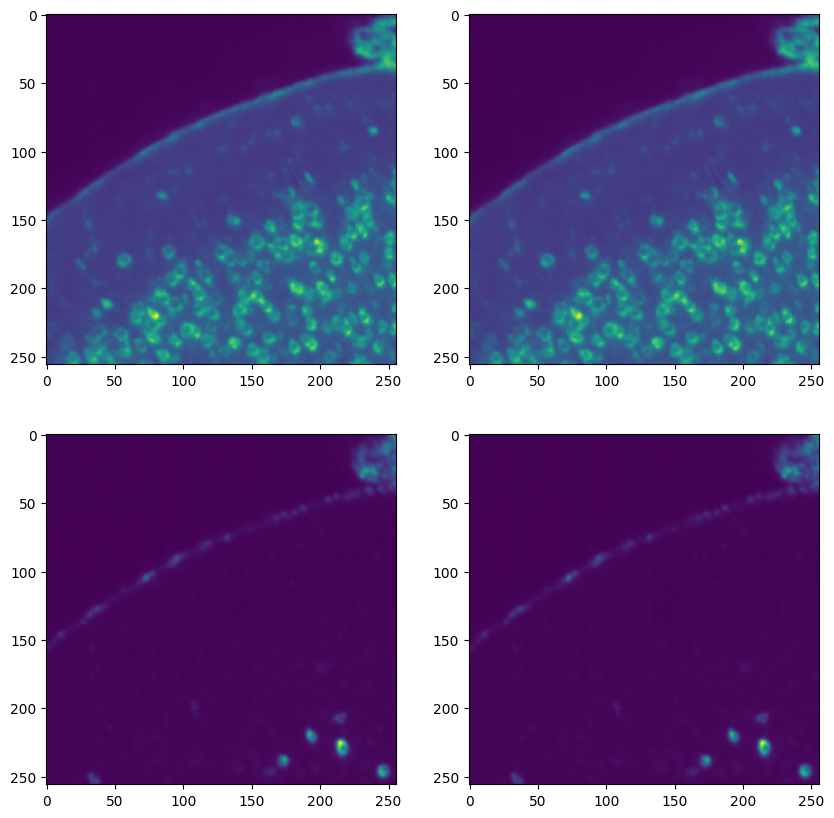

In [197]:
fig, ax = plt.subplots(2,2, figsize = (10,10))
ax[0][0].imshow(oirginal_img[0])
ax[0][1].imshow(crop_img[0])
ax[1][0].imshow(oirginal_img[1])
ax[1][1].imshow(crop_img[1])
print('is same? ', np.sum(np.equal(oirginal_img[0],crop_img[0]))== 65536)
print('is same? ', np.sum(np.equal(oirginal_img[1],crop_img[1]))== 65536)

In [198]:
oirginal_mask = tf.imread('/mnt/aperto/yin/cellpose_training/data/image_masks/0002_mask.tif')
crop_mask = tf.imread('./crops/0002_mask1.tif')

is same?  False


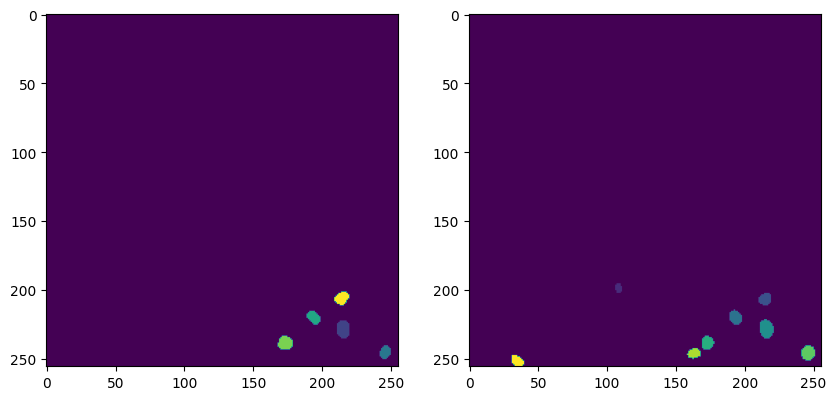

In [200]:
fig, ax = plt.subplots(1,2, figsize = (10,10))
ax[0].imshow(oirginal_mask)
ax[1].imshow(crop_mask)
print('is same? ', np.sum(np.equal(oirginal_mask,crop_mask))== 65536)
# this should be different since one is original ground truth and another is cellpose prediction

In [201]:
crop_mask1 = tf.imread('./crops/0002_mask1.tif')
crop_mask2 = tf.imread('./crops/0002_mask2.tif')
crop_mask3 = tf.imread('./crops/0002_mask3.tif')

is same?  True


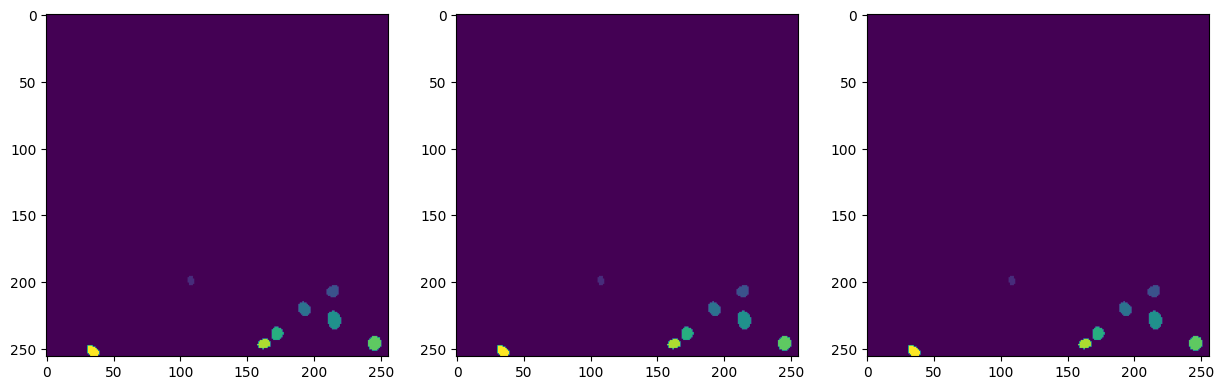

In [202]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
ax[0].imshow(crop_mask1)
ax[1].imshow(crop_mask2)
ax[2].imshow(crop_mask3)
print('is same? ', np.sum(np.equal(crop_mask1,crop_mask2, crop_mask3))== 65536)